IMPORTING LIBRARIES

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.math import  confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Upload vgg16 pretrained model to use it in the transfer learning
from tensorflow.keras.applications import VGG16
import random
random.seed(10)
import warnings
warnings.filterwarnings('ignore')

2024-08-28 16:34:38.685664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 16:34:38.685780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 16:34:38.819624: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define the directories and image size
train_directory = '/kaggle/input/cat-and-dog/training_set/training_set'
test_directory = '/kaggle/input/cat-and-dog/test_set/test_set'
categories = ['cats', 'dogs']  # Update with actual category names
image_size = 120

In [3]:
path_main = "/kaggle/input/cat-and-dog/training_set/training_set"   #number of elements in train folder cats and dogs
for folder in os.listdir(path_main):
    list_of_elements = os.listdir(os.path.join(path_main, folder)) 
    
    print(f'Folder: {folder}\n')
    print(f'Number of elements: {len(list_of_elements)}\n')
    print(f'First 3 item\'s name: {list_of_elements[:3]}\n')
    print('***************************')

Folder: dogs

Number of elements: 4006

First 3 item's name: ['dog.3443.jpg', 'dog.1942.jpg', 'dog.375.jpg']

***************************
Folder: cats

Number of elements: 4001

First 3 item's name: ['cat.3498.jpg', 'cat.891.jpg', 'cat.2842.jpg']

***************************


In [4]:
path_main = "/kaggle/input/cat-and-dog/test_set/test_set"   #number of elements in test folder cats and dogs
for folder in os.listdir(path_main):
    list_of_elements = os.listdir(os.path.join(path_main, folder)) 
    
    print(f'Folder: {folder}\n')
    print(f'Number of elements: {len(list_of_elements)}\n')
    print(f'First 3 item\'s name: {list_of_elements[:3]}\n')
    print('***************************')

Folder: dogs

Number of elements: 1013

First 3 item's name: ['dog.4329.jpg', 'dog.4223.jpg', 'dog.4253.jpg']

***************************
Folder: cats

Number of elements: 1012

First 3 item's name: ['cat.4414.jpg', 'cat.4420.jpg', 'cat.4880.jpg']

***************************


In [5]:
def plot_imgs(item_dir, num_imgs=10):
    
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.title(f'{img_path}'[-10:-4])
        plt.imshow(img)

    plt.tight_layout()
    
cats_path = "/kaggle/input/cat-and-dog/training_set/training_set/cats"
dogs_path = "/kaggle/input/cat-and-dog/training_set/training_set/dogs"   

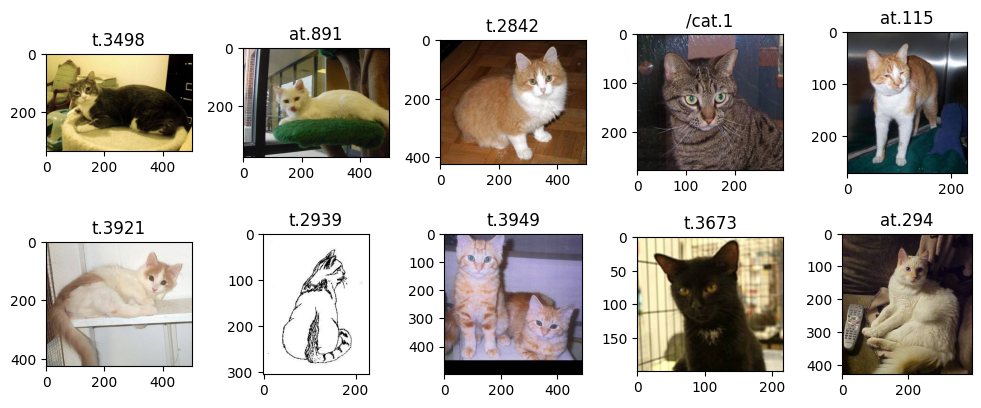

In [6]:
plot_imgs(cats_path, num_imgs=10)

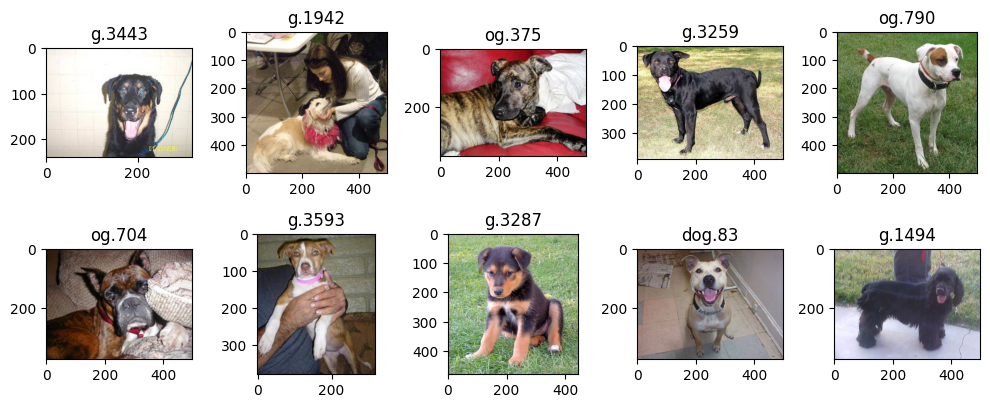

In [7]:
plot_imgs(dogs_path, num_imgs=10)

In [8]:
# Load training dataset
train_data = []
#plt.figure(figsize=(10, 10))
for label in range(len(categories)):
    class_name = categories[label]
    class_path = os.path.join(train_directory, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image_resized = cv2.resize(image, (image_size, image_size))
            train_data.append([image_resized, label])

In [9]:
print(f"we have {len(train_data)} items in x_train")

we have 8005 items in x_train


In [10]:
# Load test dataset
test_data = []
for label in range(len(categories)):
    class_name = categories[label]
    class_path = os.path.join(test_directory, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image_resized = cv2.resize(image, (image_size, image_size))
            test_data.append([image_resized, label])

In [11]:
print(f"we have {len(test_data)} items in x_test")

we have 2023 items in x_test


In [12]:
# Shuffle training data
random.shuffle(train_data)

In [13]:
# Split training data into features and labels
X_train = np.array([i[0] for i in train_data])
Y_train = np.array([i[1] for i in train_data])

# Split test data into features and labels
X_test = np.array([i[0] for i in test_data])
Y_test = np.array([i[1] for i in test_data])

In [14]:
# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

In [15]:
# Checking for any missing values
print("Training data has missing values:", np.isnan(X_train).any())
print("Testing data has missing values:", np.isnan(X_test).any())

Training data has missing values: False
Testing data has missing values: False


In [16]:
model = Sequential([

Conv2D(64, (3, 3), activation='relu', input_shape=(image_size,image_size, 3)),
Conv2D(64, (3, 3), activation='relu'),    
MaxPooling2D(pool_size=(2, 2)),
#Dropout(0.1),

Conv2D(128, (3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
#Dropout(0.2),

Conv2D(64, (3, 3), activation='tanh'),
MaxPooling2D(pool_size=(2, 2)),
#Dropout(0.1),
    
Conv2D(32, (3, 3), activation='sigmoid'),
MaxPooling2D(pool_size=(2, 2)),
#Dropout(0.1),    

Flatten(),
Dense(256, activation='relu'),
Dense(128, activation='relu'),
Dense(8, activation='relu'),      
#Dropout(0.2),
Dense(1, activation='sigmoid'), # 2 because we have cat and dog classes
      ])      

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 116, 116, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443,825 (1.69 MB)

 Trainable params: 443,825 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train model
history = model.fit(X_train, Y_train,batch_size= 100, epochs=20, validation_data=(X_test, Y_test))

Epoch 1/20
 2/81 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.4375 - loss: 0.8234  

I0000 00:00:1724862998.135025      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 152ms/step - accuracy: 0.4875 - loss: 0.7088 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.4932 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.4912 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.4880 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.5040 - loss: 0.6931 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.4985 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6931
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.5081 - loss: 0.6931 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.4989 - loss: 0.6931 - val_accuracy: 0.4998 - val_loss: 

In [20]:
accuracy = model.evaluate(X_test, Y_test)[1]
print(f"Accuracy: {accuracy * 100:.2f}%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8330 - loss: 0.6905
Accuracy: 49.98%


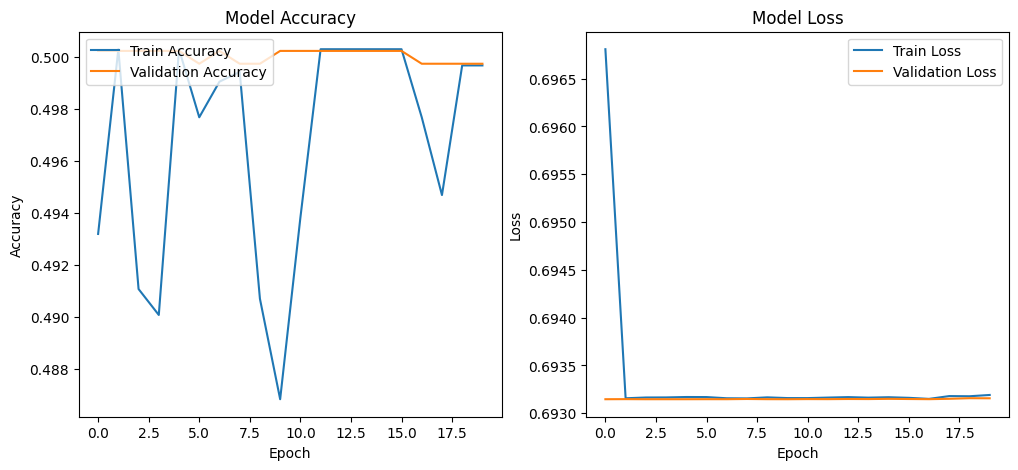

In [21]:
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 5))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()
